# Gradient Boosting

As we have seen, Random Forest is an ensemble learning method, which predicts by combining outputs from individual trees. It uses deep decision trees (low bias, high variance) and combines them, which reduces the variance. 
Another approach is to combine weak learners (high bias, low variance). In case of decision trees, this means that shallow trees are used. It reduces the high bias by adding a classifier at a time, the next classifier is trained to improve the previous trained ensemble.

More formally: Suppose we have a weak learner $W(x, \omega)$, where $x$ is our input vector and $\omega$ the parameters of the model. In case of trees, $\omega$ is:

$$
\omega = \{R_p, c_p\} \Big\rvert_{p=1}^{p=P}
$$

$P$ is the number of partitions, $R_p$ the region and $c_p$ its value for a given partition. The goal is to have after $M$ iterations steps, a function $f_M$ which adds multiple weak models $f_m$ together.
At each step $m$, we improve the previous model by adding a weak learner with a learning rate $\rho_m$ (also known as shrinkage parameter):

$$
f_m(x) = f_{m-1}(x) + \rho_m W_m(x, \omega_m)
$$

The initial step $f_0$ can be set to 0 or to the average of the output vector $y$.
Motivated by gradient descent, to find the parameters for the weak learner $W_m$, we take the gradient of the loss function $J$ to calculate the direction of our steps. The gradient $r_{im}$ (also known as residual) is:

$$
r_{im} = -\Big( \frac{\partial J(y^{(i)}, f(x^{(i)}))}{\partial f(x^{(i)}) } \Big)_{f(x^{(i)})=f_{m-1}(x^{(i)})}
$$

We use this gradient to calculate the parameters for the weak learner $W_m$ by fitting a model to the negative gradient:

$$
\omega_m = \operatorname*{arg\,min}_{\omega} \sum_{i=1}^{N} J(r_{im}, W(x^{(i)}, \omega))
$$

The learning rate $\rho_m$ can be either fixed or can be computed:

$$
\rho_m = \operatorname*{arg\,min}_{\rho} \sum_{i=1}^{N} J(y^{(i)}, f_{m-1}(x) + \rho W_m(x, \omega_m))
$$

## Summarization

1. Initialize $f_0(x) = 0$ or $f_0 = \frac{1}{N} \sum y^{(i)}$

2. For $m = 1$ to M:
    
    (a) Compute: 
    $$
    r_{im} = -\Big( \frac{\partial J(y^{(i)}, f(x^{(i)}))}{\partial f(x^{(i)}) } \Big)_{f(x^{(i)})=f_{m-1}(x^{(i)})}
    $$
    
    (b) Fit model to residuals:
    $$
    \omega_m = \operatorname*{arg\,min}_{\omega} \sum_{i=1}^{N} J(r_{im}, W(x^{(i)}, \omega))
    $$
    
    (c) Choose fixed step size $\rho_m$ or compute it
    
    (d) Take the step:
    $$
    f_m(x) = f_{m-1}(x) + \rho_m W_m(x, \omega_m)
    $$
    
3. Output: 

$$
f_m(x) = f_0(x) + \sum_{m=1}^M \rho_m W_m(x, \omega_m)
$$

### Example for MSE

Mean squared error (MSE) is a quite common loss function. For a pair $(x^{(i)}, y^{(i)})$ the loss is calculated in the following way:

$$
J(y^{(i)}, f(x^{(i)}) = \frac{1}{2} (y^{(i)} - f(x^{(i)}))^2
$$

Thus, the gradient $r_{im}$ becomes:

$$
r_{im} = y^{(i)} - f_{m-1}(x^{(i)})
$$

So, at every step, we try to correct the error from the previous step by fitting a model to it.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeRegressor


class GradientBoostingRegressor(object):
    
    def __init__(
        self,
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3
    ):
        self._learning_rate = learning_rate
        self._n_estimators = n_estimators
        self._max_depth = max_depth
        self._estimators = []
        
    def _create_tree(self):
        return DecisionTreeRegressor(
            criterion='mse',
            max_depth=self._max_depth
        )
    
    def _negative_gradient(self, y, y_pred):
        return y - y_pred
        
    def fit(self, X, y):
        raw_predictions = np.zeros(y.shape)
        
        for _ in range(self._n_estimators):
            tree = self._create_tree()
            residual = self._negative_gradient(y, raw_predictions)
            tree.fit(X, residual)
            self._estimators.append(tree)
            
            raw_predictions[:, 0] += self._learning_rate * tree.predict(X)
            
        return self
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for estimator in self._estimators:
            y_pred += self._learning_rate * estimator.predict(X)
        return y_pred

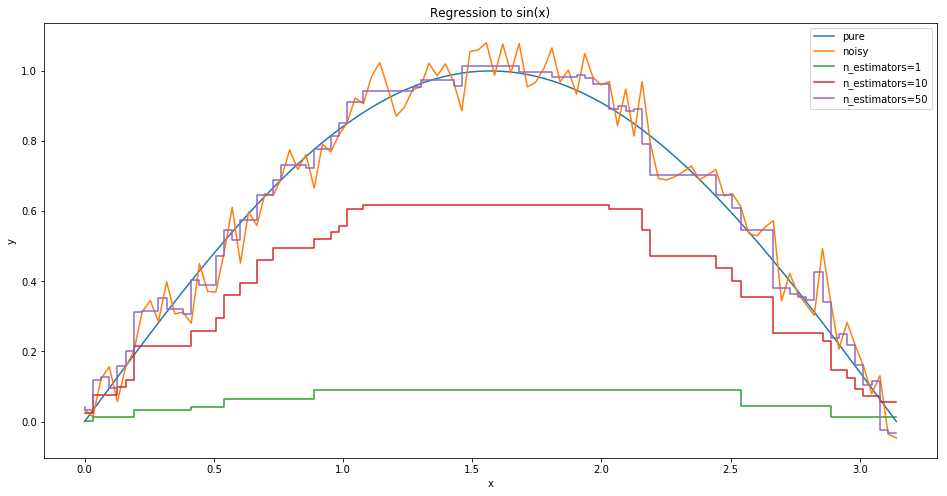

In [3]:
X = np.linspace(0, np.pi, 100).reshape(-1, 1)
y_pure = np.sin(X)
y_noisy = y_pure + np.random.normal(0, 0.07, X.shape)

fig, ax = plt.subplots()
ax.plot(X, y_pure, label='pure')
ax.plot(X, y_noisy, label='noisy')

for n_estimators in (1, 10, 50):
    y_predicted = GradientBoostingRegressor(
        n_estimators=n_estimators
    ).fit(X, y_noisy).predict(X)
    ax.step(X, y_predicted, label='n_estimators={}'.format(n_estimators))

ax.legend()
ax.set(
    xlabel='x',
    ylabel='y',
    title='Regression to sin(x)'
)
fig.set_size_inches(w=16, h=8)